From the bonus question I try to make sure that the parameters produce state |01>+|10>.<br>
The problem is when I measurement the circuit, the state vector with complex number collapse into real number.<br>
In the <a href="Task_2_Part_1.ipynb"> privous part</a>, I tried to rotate the qubit before measurement but it does not give enough information.<br>
This time I calculate the gradient directly from state vector without measurements.

In [1]:
import numpy as np
from qiskit import *
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import Aer
from sympy import *
from sympy.physics.quantum import TensorProduct
import sympy

Import sympy for doing the tensor product and differential the circuit. <br>
import qiskit to draw circuit and check the result.

# Draw the circuit
Use qiskit just to draw the circuit. The optimization has nothing to do with qiskit.

In [2]:
def circuit(params):
    circ = QuantumCircuit(2)
    circ.rx(params[0],0)
    circ.rx(params[1],1)
    circ.ry(params[2],0)
    circ.ry(params[3],1)
    circ.cx(0,1)
    return circ

circuit(['theta0','theta1','theta2','theta3']).draw()

┌────────────┐┌────────────┐     
q_0: ┤ RX(theta0) ├┤ RY(theta2) ├──■──
     ├────────────┤├────────────┤┌─┴─┐
q_1: ┤ RX(theta1) ├┤ RY(theta3) ├┤ X ├
     └────────────┘└────────────┘└───┘

# Make RX, RY, CNOT in sympy Matrix

In [3]:
def get_rx_matrix(symbol='x'):
    x = symbols(symbol)
    rx_matrix = Matrix([
        [cos(x/2)     ,-1.j*sin(x/2)],
        [-1.j*sin(x/2), cos(x/2)]
    ])
    return rx_matrix

#ry
def get_ry_matrix(symbol='x'):
    x = symbols(symbol)
    ry_matrix = Matrix([
        [cos(x/2) ,-sin(x/2)],
        [sin(x/2), cos(x/2)]
    ])
    return ry_matrix

# cnot
cnot_matrix = Matrix([
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0]
])

In [4]:
## example of rx gate
get_rx_matrix('theta')

Matrix([
[       cos(theta/2), -1.0*I*sin(theta/2)],
[-1.0*I*sin(theta/2),        cos(theta/2)]])

In [5]:
## example of ry gate
get_ry_matrix('theta')

Matrix([
[cos(theta/2), -sin(theta/2)],
[sin(theta/2),  cos(theta/2)]])

# Create the circuit
The structure of circuit that I construct is<br>
<div>
    <img src="images/Circuit.JPG"  style="width: 400px; lign: left;" align="left">
</div>


The circuits devides into 3 Matrix M1, M2, M3.<br>
The matrix M1 and M2 are Tensor product of quantum gates in its block and M3 is CNOT gate.<br>
$M1 = RX(\theta_0)⊗ RX(\theta_1)$<br>
$M2 = RY(\theta_2)⊗ RY(\theta_3)$<br>
$M3 = CNOT$

In [7]:
M3 = cnot_matrix
M2 = TensorProduct(get_ry_matrix('w[3]'),get_ry_matrix('w[2]'))
M1 = TensorProduct(get_rx_matrix('w[1]'),get_rx_matrix('w[0]'))

The unitary matrix that represent the circuit is $M3 * M2 * M1$.

In [8]:
unitary = (M3*M2)*M1

input is state |00>

In [11]:
input_matrix = Matrix([
    [1],
    [0],
    [0],
    [0]
])

state vector<br>
$|\varphi> = (M3*M2*M1)|00>$

In [12]:
state_matrix = unitary*input_matrix

# Equation for calculus

In [13]:
## other state
_00 = Matrix([[1,0,0,0]]) # state |00>
_01 = Matrix([[0,1,0,0]]) # state |01>
_10 = Matrix([[0,0,1,0]]) # state |10>
_11 = Matrix([[0,0,0,1]]) # state |11>

In [15]:
# probability equation of eacch state
state00 = _00*state_matrix
state01 = _01*state_matrix
state10 = _10*state_matrix
state11 = _11*state_matrix

parameters symbol for sympy

In [16]:
# w0 = symbols('w[0]')
# w1 = symbols('w[1]')
# w2 = symbols('w[2]')
# w3 = symbols('w[3]')

In [17]:
w = symbols('w')

# loss equation
from final state <br>
$|\varphi> = \alpha_0|00> + \alpha_1|01> + \alpha_2|10> + \alpha_3|11>$<br>
The loss function is 
$loss = (\sqrt{0.5}-\alpha_1) + (\sqrt{0.5} - \alpha_2) $
Which surely produce state $\sqrt{0.5}|01> + \sqrt{0.5}|10>$ when optimized

In [94]:
loss = (state01-Matrix([[0.5**0.5]])) + (state10-Matrix([[0.5**0.5]]))

Create lambda function using loss equation

In [95]:
get_loss = lambdify(w,loss)

# Differentiation by each parameters
Differentation will be don using sympy which return the equations below

In [96]:
diff_w0_eq = diff(loss,symbols('w[0]')).doit()
diff_w1_eq = diff(loss,symbols('w[1]')).doit()
diff_w2_eq = diff(loss,symbols('w[2]')).doit()
diff_w3_eq = diff(loss,symbols('w[3]')).doit()

In [97]:
diff_w0_eq

Matrix([[0.5*I*sin(w[0]/2)*sin(w[1]/2)*sin(w[2]/2)*cos(w[3]/2) + 0.5*I*sin(w[0]/2)*sin(w[1]/2)*cos(w[2]/2)*cos(w[3]/2) - sin(w[0]/2)*sin(w[2]/2)*sin(w[3]/2)*cos(w[1]/2)/2 - sin(w[0]/2)*sin(w[3]/2)*cos(w[1]/2)*cos(w[2]/2)/2 + 0.5*sin(w[1]/2)*sin(w[2]/2)*cos(w[0]/2)*cos(w[3]/2) - 0.5*sin(w[1]/2)*cos(w[0]/2)*cos(w[2]/2)*cos(w[3]/2) + 0.5*I*sin(w[2]/2)*sin(w[3]/2)*cos(w[0]/2)*cos(w[1]/2) - 0.5*I*sin(w[3]/2)*cos(w[0]/2)*cos(w[1]/2)*cos(w[2]/2)]])

## Create lambda function from equation above

In [114]:
diff_w0 = lambdify(w,diff_w0_eq)
diff_w1 = lambdify(w,diff_w1_eq)
diff_w2 = lambdify(w,diff_w2_eq)
diff_w3 = lambdify(w,diff_w3_eq)

### init params

In [115]:
init_params = np.random.rand(4)
init_params

array([0.09252209, 0.79794909, 0.37638649, 0.30084828])

# Optimize parameters

In [116]:
error = []
params = init_params
for i in range(0,1000):
    error.append((get_loss(params)[0][0])**2)
    dw0 = diff_w0(params)[0][0]
    dw1 = diff_w1(params)[0][0]
    dw2 = diff_w2(params)[0][0]
    dw3 = diff_w3(params)[0][0]
    gradient = 0.1*np.array([dw0,dw1,dw2,dw3]).real
    params = params+gradient

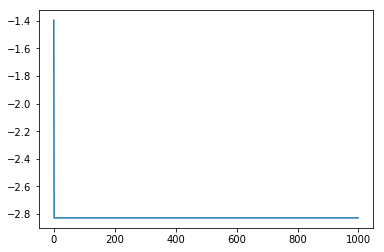

In [117]:
plt.plot(loss)

In [118]:
print('Optimized parameters:',weight)

Optimized parameters: [3.18457003e-16 1.13841903e-16 1.57079633e+00 3.14159265e+00]


# Check the answer with qiskit

In [119]:
backend = Aer.get_backend('statevector_simulator')

In [120]:
circ = circuit(params)
circ.draw()

┌───────┐┌──────────┐     
q_0: ┤ RX(0) ├┤ RY(pi/2) ├──■──
     ├───────┤└┬────────┬┘┌─┴─┐
q_1: ┤ RX(0) ├─┤ RY(pi) ├─┤ X ├
     └───────┘ └────────┘ └───┘

In [121]:
job = execute(circ, backend)
result = job.result()
print(result.get_statevector())

[2.08441800e-15+0.j 7.07106781e-01+0.j 7.07106781e-01+0.j
 2.08441800e-15+0.j]


# Bonus question

The results from optimize using state vector surely gives |01> + |10><br>
With structure like neural network that select features autometically, the result shows that RX gates are not nessassary.
RX also moves state of qubits into complex number and |-> basis, get rid of RX should also provides |01>+|10>

# Do experiment again without using RX gates

In [123]:
import pennylane as qml  ### pennylane for optimizing the circuit.
from pennylane import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set_style("darkgrid")

Same circuit but no RX gates

In [124]:
dev = qml.device("default.qubit", wires=2, analytic=True)
def circuit(params):
#     qml.RX(params[0], wires=0)
#     qml.RX(params[1], wires=1)
    qml.RY(params[2], wires=0)
    qml.RY(params[3], wires=1)
    qml.CNOT(wires=[0, 1])

    
### measurement
@qml.qnode(dev)
def get_prob(params):
    circuit(params)
    return qml.probs(wires=[0, 1])

In [125]:
print(get_prob([0,0,0,0]))
print(get_prob.draw())

[1. 0. 0. 0.]
 0: ──RY(0)──╭C──╭┤ Probs 
 1: ──RY(0)──╰X──╰┤ Probs 



Same loss function as <a href = 'Task_2_Part_1.ipynb'> Part1</a>

In [128]:
def cost(param):
    alpha = get_prob(param)
    loss = (0.5-alpha[1])**2 + (0.5-alpha[2]) **2
    return loss

In [129]:
def optimize_circuit(init_params, cost, optimizer = qml.AdamOptimizer, stepsize = 0.1, steps = 200):
    opt = optimizer(stepsize = stepsize)
    params = init_params

    lower_bound = 0
    upper_bound = np.pi
    loss = []
    for i in range(steps):
        # update the circuit parameters
        params = opt.step(cost, params)
        loss.append(cost(params))
    
    return loss,params

optimized loss:  3.672349014368813e-06
optimized params:  [0.09252209 0.79794909 1.57080486 3.03742838]


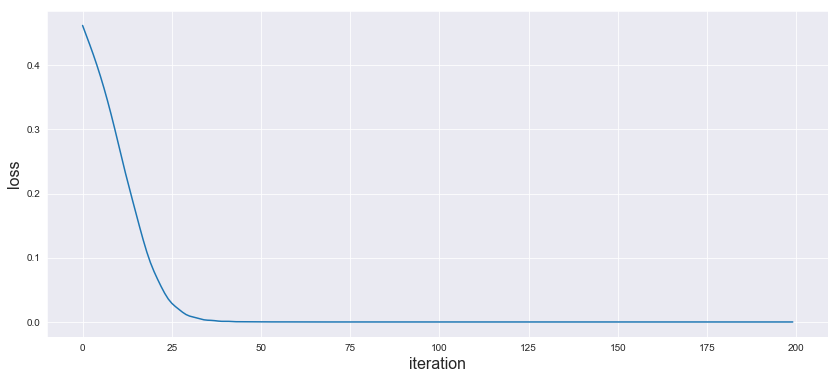

In [130]:
loss_no_noise, params = optimize_circuit(init_params,cost = cost)
print('optimized loss: ',loss_no_noise[-1])
print('optimized params: ',params)

figure(num=None, figsize=(14, 6))
plt.ylabel('loss', fontsize=16)
plt.xlabel('iteration', fontsize=16)
plt.plot(loss_no_noise)

In [131]:
print('final statevector: ',dev.state)

final statevector:  [0.03681083+0.j 0.70614495+0.j 0.70615098+0.j 0.03681114+0.j]


### noisy device

In [133]:
noisy_dev = qml.device("cirq.mixedsimulator", wires=2, shots =1000 ,analytic=False)
#noisy backend

@qml.qnode(noisy_dev)
def get_probs_noisy_circuit(params):
    circuit(params)
    return qml.probs(wires=[0, 1])

# new cost function
def cost_noisy_circuit(param):
    alpha = get_probs_noisy_circuit(param)
    loss = (0.5-alpha[1])**2 + (0.5-alpha[2])**2
    return loss

In [134]:
def show_result(loss, params):
    print('optimized loss: ',loss[-1])
    print('optimized params: ',params)

    figure(num=None, figsize=(14, 6))
    plt.ylabel('loss', fontsize=16)
    plt.xlabel('iteration', fontsize=16)
    plt.plot(loss)

    print('probability: ',get_probs_noisy_circuit(params))

### 1 shot per iteration

In [135]:
noisy_dev.shots = 1
loss_1shot, params = optimize_circuit(init_params, cost = cost_noisy_circuit)

optimized loss:  0.5
optimized params:  [0.09252209 0.79794909 1.42241813 2.55043414]
probability:  [0. 1. 0. 0.]


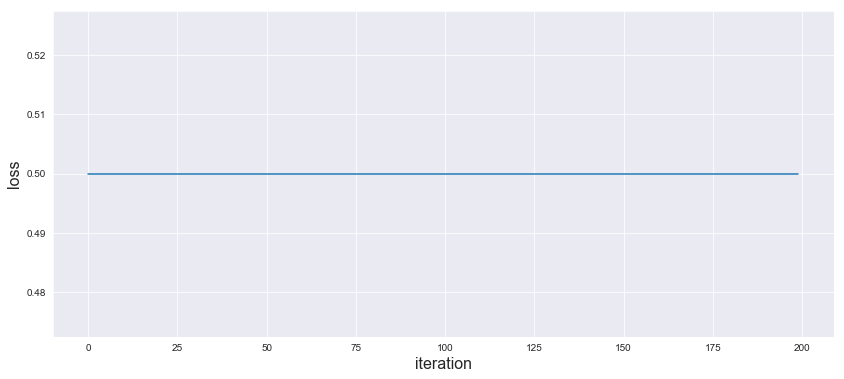

In [136]:
show_result(loss_1shot, params)

### 10 shot per iteration

In [137]:
noisy_dev.shots = 10
loss_10shot, params = optimize_circuit(init_params, cost = cost_noisy_circuit)

optimized loss:  0.07999999999999999
optimized params:  [0.09252209 0.79794909 1.76544039 3.15565614]
probability:  [0.  0.3 0.7 0. ]


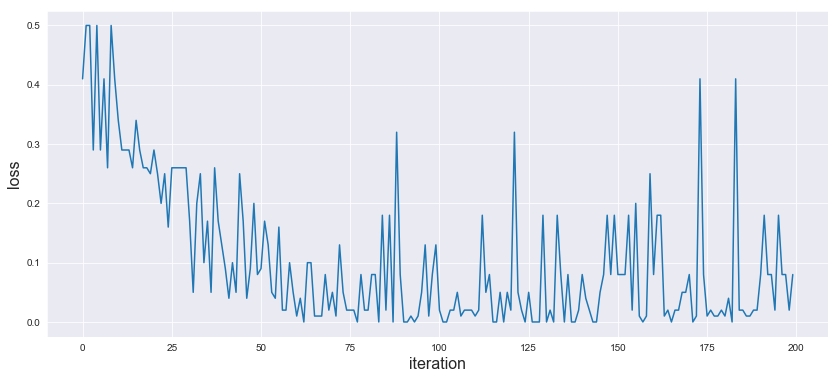

In [138]:
show_result(loss_10shot, params)

### 100 shot per iteration

In [139]:
noisy_dev.shots = 100
loss_100shot, params = optimize_circuit(init_params, cost = cost_noisy_circuit)

optimized loss:  0.0032000000000000015
optimized params:  [0.09252209 0.79794909 1.62656047 3.0861511 ]
probability:  [0.   0.49 0.51 0.  ]


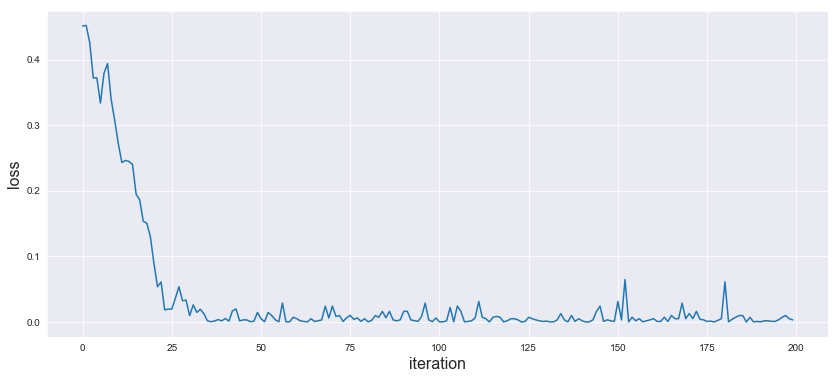

In [140]:
show_result(loss_100shot, params)

### 1000 shot per iteration

In [141]:
noisy_dev.shots = 1000
loss_1000shot, params = optimize_circuit(init_params, cost = cost_noisy_circuit)

optimized loss:  0.0016900000000000031
optimized params:  [0.09252209 0.79794909 1.61035096 3.0402    ]
probability:  [0.001 0.46  0.538 0.001]


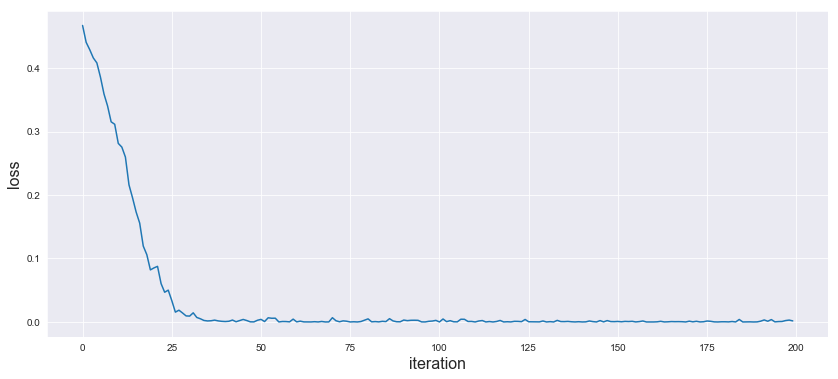

In [143]:
show_result(loss_1000shot, params)

### Compare Results

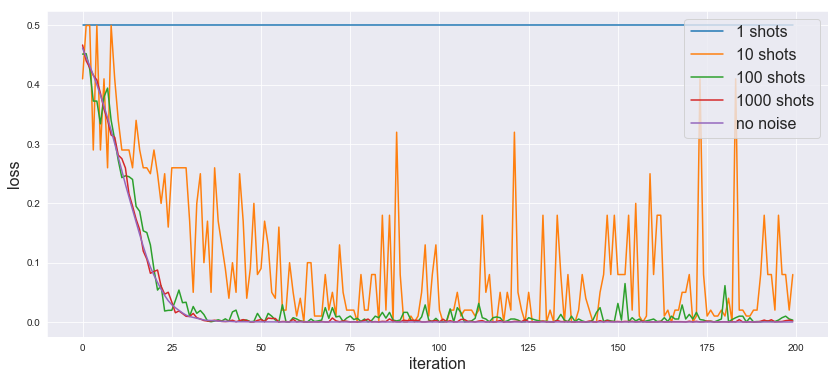

In [144]:
figure(num=None, figsize=(14, 6))
plt.ylabel('loss', fontsize=16)
plt.xlabel('iteration', fontsize=16)

plt.plot(loss_1shot, label = '1 shots')
plt.plot(loss_10shot, label = '10 shots')
plt.plot(loss_100shot, label = '100 shots')
plt.plot(loss_1000shot, label = '1000 shots')
plt.plot(loss_no_noise, label = 'no noise')

plt.legend(loc="upper right", fontsize=16)


# Conclusion

From the experiment with different measurement per iteration, the more shots in the experiment give us more precise probability that effect gradient and loss in each iteration. <br>
For the bonus question I tried to measure 2 different basis in the same iteration. The result provides |01> + |10> but not all the time.<br>
To make sure that the circuit provides |01> + |10>, not using RX can garantee that optimized parameters will gives only |01>+|10>.

# Reference
textbook: <br>https://qiskit.org/textbook/preface.html <br>
          https://www.youtube.com/watch?v=Ui-SUh6IfkA <br>
Sympy: https://docs.sympy.org/latest/index.html <br>
Pennylane: https://pennylane.readthedocs.io/en/stable/ <br>